In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Neural Process for age estimation(multi-task)

This notebook shows how to train and sample from a Neural Process for a class of age estimation in multi-task learning way
There are (num_of_persons) tasks.
In each task, there are (num_of_images) context points

### Read Dataset

In [2]:
from lib.datasets.datasets import FaceFeatureData

# Create dataset

num_of_people = 3
num_of_images=18
dataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images)

#82 different people(batch_num)
#18 different images each people(batch_size)
#x_dim = 2048

### Build Neural Process

In [3]:
from lib.core.neural_process import NeuralProcess

x_dim = 2048
y_dim = 1
r_dim = 50  # Dimension of representation of context points
z_dim = 50  # Dimension of sampled latent variable
h_dim = 50  # Dimension of hidden layers in encoder and decoder

neuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)

### Train Neural Process 1st time
the first time(all the parameter will be updated)

Epoch: 0, Avg_loss: 14329.010904947916
Epoch: 1, Avg_loss: 13908.953287760416
Epoch: 2, Avg_loss: 13319.257486979166
Epoch: 3, Avg_loss: 12912.617838541666
Epoch: 4, Avg_loss: 12328.232259114584
Epoch: 5, Avg_loss: 11724.7255859375
Epoch: 6, Avg_loss: 11125.820475260416
Epoch: 7, Avg_loss: 10436.082356770834
Epoch: 8, Avg_loss: 9554.957356770834
Epoch: 9, Avg_loss: 8663.763509114584
Epoch: 10, Avg_loss: 7817.687662760417
Epoch: 11, Avg_loss: 6946.447428385417
Epoch: 12, Avg_loss: 6055.464680989583
Epoch: 13, Avg_loss: 5161.667887369792
Epoch: 14, Avg_loss: 4339.687174479167
Epoch: 15, Avg_loss: 3656.6786295572915
Epoch: 16, Avg_loss: 2888.5465494791665
Epoch: 17, Avg_loss: 2283.4894205729165
Epoch: 18, Avg_loss: 1870.7166748046875
Epoch: 19, Avg_loss: 1600.0711873372395
Epoch: 20, Avg_loss: 1204.709452311198
Epoch: 21, Avg_loss: 1048.1970723470051
Epoch: 22, Avg_loss: 756.7370198567709
Epoch: 23, Avg_loss: 611.4042765299479
Epoch: 24, Avg_loss: 519.7869669596354
Epoch: 25, Avg_loss: 39

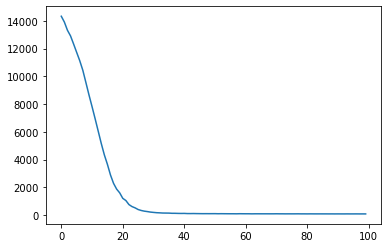

In [4]:
from torch.utils.data import DataLoader
from lib.core.training import NeuralProcessTrainer

batch_size = 1
num_context = 17
num_target = 1

data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
optimizer = torch.optim.Adam(neuralprocess.parameters(), lr=3e-4)
np_trainer = NeuralProcessTrainer(device, neuralprocess, optimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)

neuralprocess.training = True
np_trainer.train(data_loader, 100)
#save first model parameters trained on the whole dataset
torch.save(neuralprocess.state_dict(), r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\firstWholeTrained.ckpt')
plt.plot(range(len(np_trainer.epoch_loss_history)),np_trainer.epoch_loss_history)
plt.show()


### Train Neural Process 2nd time
(the parameter of encoder will be frozen)

the structure of neural process network(3-layer network):
layer 1: xy_to_r

layer 2: r_to_mu_sigma

layer 3: xz_to_y


Epoch: 0, Avg_loss: 78.29261016845703
Epoch: 1, Avg_loss: 78.57067108154297
Epoch: 2, Avg_loss: 80.35750579833984
Epoch: 3, Avg_loss: 77.80778503417969
Epoch: 4, Avg_loss: 79.92034912109375
Epoch: 5, Avg_loss: 80.55928039550781
Epoch: 6, Avg_loss: 77.89131927490234
Epoch: 7, Avg_loss: 77.69308471679688
Epoch: 8, Avg_loss: 81.92761993408203
Epoch: 9, Avg_loss: 77.983642578125
Epoch: 10, Avg_loss: 82.55131530761719
Epoch: 11, Avg_loss: 78.04424285888672
Epoch: 12, Avg_loss: 77.43148803710938
Epoch: 13, Avg_loss: 80.28347778320312
Epoch: 14, Avg_loss: 79.53968811035156
Epoch: 15, Avg_loss: 77.60054779052734
Epoch: 16, Avg_loss: 82.30230712890625
Epoch: 17, Avg_loss: 81.50679779052734
Epoch: 18, Avg_loss: 77.67724609375
Epoch: 19, Avg_loss: 77.9867935180664
Epoch: 20, Avg_loss: 80.02529907226562
Epoch: 21, Avg_loss: 79.91383361816406
Epoch: 22, Avg_loss: 77.71575164794922
Epoch: 23, Avg_loss: 81.51380157470703
Epoch: 24, Avg_loss: 79.87263488769531
Epoch: 25, Avg_loss: 77.78925323486328
Ep

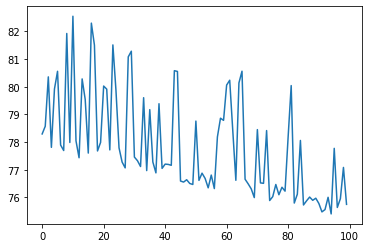

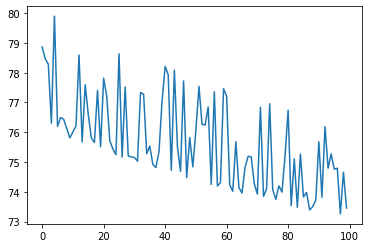

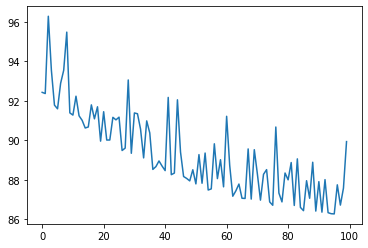

In [5]:
singlePersonDatasets = []
for idx in range(num_of_people):
    singlePersonDataset = FaceFeatureData(num_of_people=num_of_people,num_of_images=num_of_images,index=idx)
    singlePersonDatasets.append(singlePersonDataset)

for idx, singlePersonDataset in enumerate(singlePersonDatasets):
    #load model

    smallNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    smallNeuralprocess.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\firstWholeTrained.ckpt'))
    #Freeze the encoder part of each model
    for child in smallNeuralprocess.children():
        for param in child.parameters():
            param.requires_grad = False
        break
    singleData_loader = DataLoader(singlePersonDataset, batch_size=batch_size, shuffle=True)
    smallOptimizer = torch.optim.Adam(smallNeuralprocess.parameters(), lr=3e-5)
    smallNp_trainer = NeuralProcessTrainer(device, smallNeuralprocess, smallOptimizer,
                                  num_context_range=(num_context, num_context),
                                  num_extra_target_range=(num_target, num_target), 
                                  print_freq=200)
    smallNeuralprocess.training = True
    smallNp_trainer.train(singleData_loader, 100)
    #save first model parameters trained on the whole dataset
    path = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    torch.save(smallNeuralprocess.state_dict(),path)
    plt.plot(range(len(smallNp_trainer.epoch_loss_history)),smallNp_trainer.epoch_loss_history)
    plt.show()



### Construct input to MergeNet
Let new dataset(new person who is not in trainset)

In [6]:
from lib.utils.utils import context_target_split
from lib.datasets.datasets import FaceFeatureTestData
import os


for batch in data_loader:
    break
# Use batch to create random set of context points
x, y = batch
x_context, y_context, _, _ = context_target_split(x[0:1], y[0:1], 
                                                  num_context, 
                                                  num_target)

modelPath = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained'
models = os.listdir(modelPath)
smallModels = map(lambda x: os.path.join(modelPath, x), models)

num_of_test_images = 18
test_target = 0
resultsOnPretrainedModelsList = [] 
for idx, root_dir in enumerate(smallModels):
    #load model
    testNeuralprocess = NeuralProcess(x_dim, y_dim, r_dim, z_dim, h_dim)
    testModelPath = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\age_estimation\smallTrained\smallTrained' + str(idx) + r'.ckpt'
    testNeuralprocess.load_state_dict(torch.load(testModelPath))
    testNeuralprocess.training = False

    testDataset = FaceFeatureTestData()
    testData_loader = DataLoader(testDataset, batch_size=batch_size, shuffle=True)
    resultsOnPretrainedModel = []
    for x_target, y_target in testData_loader:
        test_target = y_target
        avg_mu = 0
        for i in range(10):
            p_y_pred = testNeuralprocess(x_context, y_context, x_target)
            # Extract mean of distribution
            mu = p_y_pred.loc.detach()
            avg_mu += mu
        avg_mu = avg_mu / 10
        avg_mu = avg_mu.view(18)
        resultsOnPretrainedModel.append(avg_mu.tolist())
    resultsOnPretrainedModelsList.append(resultsOnPretrainedModel)

resultsOnPretrainedModels = []
for i in range(num_of_test_images):
    resultsWithSinglePerson = []
    for list in resultsOnPretrainedModelsList:
        resultsWithSinglePerson.append(list[0][i])
    resultsOnPretrainedModels.append(resultsWithSinglePerson)
resultsOnPretrainedModels = torch.FloatTensor(resultsOnPretrainedModels)

### Training MergeNet

Epoch: 0, loss: 2273.36669921875
Epoch: 1, loss: 2263.6943359375
Epoch: 2, loss: 2254.046142578125
Epoch: 3, loss: 2244.421875
Epoch: 4, loss: 2234.82275390625
Epoch: 5, loss: 2225.248046875
Epoch: 6, loss: 2215.698974609375
Epoch: 7, loss: 2206.175537109375
Epoch: 8, loss: 2196.6787109375
Epoch: 9, loss: 2187.2080078125
Epoch: 10, loss: 2177.763916015625
Epoch: 11, loss: 2168.34765625
Epoch: 12, loss: 2158.958740234375
Epoch: 13, loss: 2149.597900390625
Epoch: 14, loss: 2140.2646484375
Epoch: 15, loss: 2130.9599609375
Epoch: 16, loss: 2121.6845703125
Epoch: 17, loss: 2112.43798828125
Epoch: 18, loss: 2103.220458984375
Epoch: 19, loss: 2094.032470703125
Epoch: 20, loss: 2084.874267578125
Epoch: 21, loss: 2075.746337890625
Epoch: 22, loss: 2066.648193359375
Epoch: 23, loss: 2057.580322265625
Epoch: 24, loss: 2048.54345703125
Epoch: 25, loss: 2039.537109375
Epoch: 26, loss: 2030.5614013671875
Epoch: 27, loss: 2021.6171875
Epoch: 28, loss: 2012.70361328125
Epoch: 29, loss: 2003.8216552734

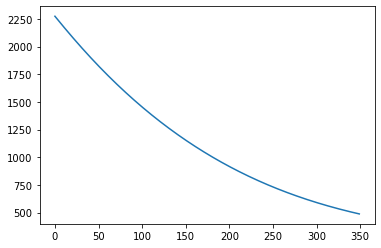

In [7]:
from lib.core.mergeNet import MergeNet

mergeNet = MergeNet(number_of_trained_people=3)
mergeOptimizer = torch.optim.Adam(mergeNet.parameters(), lr=3e-3)
mergeEpoch = 350
criterion = torch.nn.MSELoss()
test_target = test_target.view(num_of_test_images,1)
merge_loss_history = []
for epoch in range(mergeEpoch):
    mergeOptimizer.zero_grad()
    mergeResult = mergeNet(resultsOnPretrainedModels)
    loss = criterion(mergeResult, test_target)
    loss.backward()
    mergeOptimizer.step()
    print("Epoch: {}, loss: {}".format(epoch, loss))
    merge_loss_history.append(loss)
plt.plot(range(len(merge_loss_history)),merge_loss_history)
plt.show()
#save mergeNet
path = r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\mergeNet.ckpt'
torch.save(mergeNet.state_dict(),path)

In [8]:
from lib.core.multiTaskAgeEstimation import ConstructInputToMergeNet

finalTestDataset = FaceFeatureTestData(r'D:\PycharmProjects\ANP\neural-processes-oxford\FinalTestFeatureVector')
finalTestData_loader = DataLoader(finalTestDataset, batch_size=batch_size, shuffle=True)
finalResultsOnPretrainedModels = ConstructInputToMergeNet(num_of_test_images,finalTestData_loader)
testMergeNet = MergeNet(number_of_trained_people=3)
testMergeNet.load_state_dict(torch.load(r'D:\PycharmProjects\ANP\neural-processes-oxford\trained_models\mergeNet.ckpt'))

final_predict_value = testMergeNet(finalResultsOnPretrainedModels)
print('final result: ')
print(final_predict_value)
for _,target_y in finalTestData_loader:
    print(target_y)


final result: 
tensor([[32.3886],
        [31.6307],
        [31.6414],
        [32.1727],
        [30.3660],
        [31.3634],
        [32.3223],
        [30.7303],
        [32.6321],
        [31.8796],
        [31.4007],
        [30.1971],
        [31.2828],
        [31.8667],
        [31.5795],
        [32.5207],
        [31.3447],
        [32.0735]], grad_fn=<AddmmBackward>)
tensor([[[37.],
         [23.],
         [22.],
         [26.],
         [ 1.],
         [18.],
         [45.],
         [26.],
         [37.],
         [45.],
         [22.],
         [ 1.],
         [38.],
         [18.],
         [23.],
         [38.],
         [38.],
         [39.]]])
tensor([[[31.],
         [30.],
         [24.],
         [18.],
         [35.],
         [40.],
         [52.],
         [45.],
         [40.],
         [40.],
         [61.],
         [49.],
         [48.],
         [52.],
         [52.],
         [49.],
         [31.],
         [35.]]])
